In [1]:
print(1)


1


In [2]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data set-up

In [3]:
def get_sara():
    return ir_datasets.load('sara')


def dataset_to_df(sara_dataset):
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df


def get_sample_n(data, n):
    return data.sample(n=n, random_state=1)

def get_sample_frac(data, frac):
    return data.sample(frac=frac, random_state=1)

### Pre-processing

In [4]:
def proccutit(dataset):
    def pre_dict(d):
        preproc = {}
        clean = []
        clean_docus = {}
        k_to_sens = {}
        for s in d.iterrows():
            k = s[1].doc_id
            v = s[1].text
            sens = s[1].sensitivity
            v = v.split('\r\n\r\n')[1]
            cleaned_text = v
            cleaned_text = re.sub(r'\n>\n', '\n\n', cleaned_text)
            # Or replace with ''
            # Put space in #cleaned_text = re.sub(r'\n> ', '\n', cleaned_text)
            cleaned_text = re.sub(r'\n> ', '\n ', cleaned_text)                         
            cleaned_text = re.sub(r'\n\s+\n', '\n\n', cleaned_text)
            cleaned_text = re.sub(r'\?{2,}', '', cleaned_text)
            cleaned_text = re.sub(r'\n\?+', '', cleaned_text)
            cleaned_text = re.sub(r' \?+', '', cleaned_text)
            cleaned_text = re.sub(r'\?{2,}', '', cleaned_text)
            cleaned_text = re.sub(r'=20', ' ', cleaned_text)
            cleaned_text = re.sub(r'=09', ' ', cleaned_text)
            cleaned_text = re.sub(r'=\r\n', '\n', cleaned_text)
            clean.append(cleaned_text)

            cutit = cleaned_text.split('\n\n')
            sep = []
            clean_docus[k] = []
            keywords = {'To:', 'cc:', 'Sent:', 'From:', 'mailto'}
            for cut in cutit:
                if not any(keyword in cut for keyword in keywords):
                    sep.append(cut)
                else:
                    clean_docus[k].append(sep)
                    sep = []
            clean_docus[k].append(sep)
            k_to_sens[k] = sens

        preproc = {}
        ids = []
        texts = []
        sens_vals = []
        for k, v in clean_docus.items():
            if len(v) == 1:
                para = v[0][0]
                full_m = ''.join(para.split('\n'))
                if len(full_m) < 15:
                    continue
                #preproc[k] = full_m
                ids.append(k)
                texts.append(full_m)
                sens_vals.append(k_to_sens.get(k))
            else:
                for i, m in enumerate(v):
                    connected_m = []

                    # Catch footer
                    # Or maybe we could search for best/closing and cut it off after that?
                    # PII in the footer - but pretty sure annotators only considered discussion for annotation - because then every email would be personal near enough - signatures.
                    if len(m) > 1:
                        if len(m[-1]) < 4:
                            m = m[:-1]
                        
                        if '@' in m[-1] or 'fax:' in m[-1].lower() or 'Sent by:' in m[-1]:
                            m = m[:-1]
                        else:
                            pass
                            #print('SEP')
                            #print(m[-1])

                    
                    for para in m:
                        message = ''.join(para.split('\n'))
                        connected_m.append(message)

                    full_m = '\n'.join(connected_m)
                    if len(full_m) < 15:
                        continue
                    id_part = k + '_' + str(i)
                    #preproc[id_part] = full_m
                    ids.append(id_part)
                    texts.append(full_m)
                    sens_vals.append(k_to_sens.get(k))

        preproc['doc_id'] = ids
        preproc['text'] = texts
        preproc['sensitivity'] = sens_vals
        return preproc

    def cutit(datadict):
        pre = pre_dict(datadict)
        preproc_df = pd.DataFrame.from_dict(pre)
        return preproc_df

    return cutit(dataset)


### Llama 2 with SARA

In [5]:
def get_llama2(name, r):
    access_token = l2_token
    model_name = name
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=access_token)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", token=access_token, cache_dir=my_cache, revision=r)
    return tokenizer, model

def get_model_version(m, v, r=None):
    models_dict = {'get_llama2' : get_llama2}
    return models_dict.get(m)(v, r)


def get_mistral(v, r=None):
    model_name = v
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if r == None:
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", cache_dir=my_cache)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", cache_dir=my_cache, revision=r)
    return tokenizer, model


m = get_mistral
v = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer, model = m(v)

In [6]:
def llm_inference(document, prompt, model, tokenizer):
  inputs = tokenizer(prompt(document), return_tensors='pt')
  generation_config = GenerationConfig(
    # Unable to set temperature to 0 - https://github.com/facebookresearch/llama/issues/687 - use do_sample=False for greedy decoding
    do_sample=False,
    max_new_tokens=20,
  )
  output = model.generate(inputs=inputs.input_ids.cuda(), attention_mask=inputs.attention_mask.cuda(), generation_config=generation_config)
  return tokenizer.decode(output[0], skip_special_tokens=True)

def display_gen_text(output, prompt_end):
  end_template = output.find(prompt_end)
  return output[end_template:]

def prompt_to_reply(d, p, model, tokenizer, end):
  response = llm_inference(d, p, model, tokenizer)
  return display_gen_text(response, end)


# String matching on model response
def post_process_classification(classification, ground_truth):
    if 'non-sensitive' in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    elif 'sensitive' in classification.lower() and 'non-sensitive' not in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification


def clear_memory():
    # Prevents cuda out of memory
    torch.cuda.empty_cache()
    gc.collect()


# Dataset - dataframe, prompt_strategy - prompt function name
def llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    further_processing_required = {}
    # All model output
    model_responses = {}

    scikit_true = []
    scikit_pred = []

    for sample in dataset.iterrows():
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # To replace with appropriate pre-processing
        if len(sample_text) > 10000:
            continue
        
        classification = prompt_to_reply(sample_text, prompt_strategy, model, tokenizer, end_prompt)

        print(classification[9:])

        model_responses[sample[1].doc_id] = classification

        quadrant, pred = post_process_classification(classification, ground_truth)
        if pred == None:
            further_processing_required[sample[1].doc_id] = quadrant
            continue

        predictions[quadrant] = predictions.get(quadrant) + 1
        scikit_true.append(ground_truth)
        scikit_pred.append(pred)

        #clear_memory()

    return predictions, further_processing_required, model_responses, scikit_true, scikit_pred


In [7]:
def post_process_split_docs(mr, fpr, pre, df):
    clean_doc_id = {}
    ground_truths = []
    ite = -1
    for s in mr.keys(): #samp.doc_id():
        if s in fpr.keys():
            continue

        if '_' in s:
            s = s[:s.find('_')]

        val = clean_doc_id.get(s, -1)
        ite += 1

        if val == -1:
            clean_doc_id[s] = pre[ite]
            ground_truths.append((df[df.doc_id == s].sensitivity).iloc[0])
            continue

        if (val == pre[ite] or val == 1):
            continue
        
        clean_doc_id[s] = pre[ite]

    values_array = np.array(list(clean_doc_id.values()))
    #print(ground_truths)
    #print(values_array)
    return values_array, ground_truths


### Evaluation summary

In [9]:
def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()

def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    print(metric_dict)

def get_metric_dict_full(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    prec = precision_score(labels, preds, average='weighted')
    rec = recall_score(labels, preds, average='weighted')
    f2 = fbeta_score(labels, preds, average='weighted', beta=2)
    metric_dict = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'bal accuracy': bac, 'f2_score': f2}
    return metric_dict

 
#evaluation_summary("Llama-2", scikit_true, scikit_pred)

### Main experiment - main call

In [11]:
# Get dataset
# Preprocess
# Get model
# Get prompt
# Run evaluation
# Display evaluation metrics

def main_experiment(portion, portion_value, proc_meth, m, v, prompt_strategy, end_prompt, tokenizer, model):
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    if portion == 'n':
        samp = get_sample_n(sara_df, portion_value)
    else:
        samp = get_sample_frac(sara_df, portion_value)

    if proc_meth:
        proc_samp = proccutit(samp)
    else:
        proc_samp = samp
        
    #tokenizer, model = get_model_version(m, v)
    predictions, further_processing_required, model_responses, truths, preds = llm_experiment(proc_samp, prompt_strategy, model, tokenizer, end_prompt)
    new_preds, new_truths = post_process_split_docs(model_responses, further_processing_required, preds, sara_df)
    #evaluation_summary("Llama-2", truths, preds)
    #get_metric_dict("Llama-2", truths, preds)
    #print(model_responses)
    evaluation_summary("Llama-2", new_truths, new_preds)
    get_metric_dict("Llama-2", new_truths, new_preds)
    return model_responses

In [12]:
def llm_inference(document, prompt, model, tokenizer):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    encodeds = tokenizer(prompt(document), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, pad_token_id=tokenizer.pad_token_id, max_new_tokens=10, do_sample=False) #, top_k=40, num_beams=4, temperature=0.7, top_p=0.95)
    decoded = tokenizer.batch_decode(generated_ids)
    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    return decoded[0]

'\ndef llm_inference(document, prompt, model, tokenizer):\n    messages = [\n    {"role": "user", "content": prompt(document)},\n    #{"role": "assistant", "content": "This text is {\'mask\'}"}\n    ]\n    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")\n    device = \'cuda\'\n    model_inputs = encodeds.to(device)\n    arr_like = torch.ones_like(model_inputs)\n    attention_mask = arr_like.to(device)\n    generated_ids = model.generate(inputs=model_inputs, attention_mask=attention_mask, max_new_tokens=10, do_sample=False)\n    decoded = tokenizer.batch_decode(generated_ids)\n    del model_inputs\n    torch.cuda.empty_cache()\n    gc.collect()\n    print(decoded[0])\n    return decoded[0]\n\ndef llm_inference(document, prompt, model, tokenizer):\n    messages = [\n    {"role": "user", "content": prompt(document)},\n    #{"role": "assistant", "content": "This text is {\'mask\'}"}\n    ]\n\n    messages = [\n    {"role": "user", "content": "Your task is to identif

### Other Prompt families

In [13]:
# Current B1
def b1(document):
  return f"[INST] Your task is to identify documents containing sensitive personal information. Does the given text contain 'sensitive' personal information or is it 'non-sensitive'? Respond by placing your classification in a Python list and provide no further explanation. Use ['sensitive'] if the text contains sensitive personal information and ['non-sensitive'] for all other documents. \nText: {document} \n[/INST]\nClassification:"

# CoT
# Lets think step by step
def b1(document):
  return f"[INST] Your task is to identify documents containing sensitive personal information. \nText: {document} \n\nDoes the given text contain 'sensitive' personal information or is it 'non-sensitive'? Respond by placing your classification in a Python list and provide no further explanation. Use ['sensitive'] if the text contains sensitive personal information and ['non-sensitive'] for all other documents. Lets think step by step. [/INST] \nClassification:"

# 3-hop reasoning
def b1(document):
  return f"[INST] Your task is to identify documents containing sensitive personal information. \nText: {document} \n\nWhat is discussed in the document? Based on common sense, what personal information is present in the document, and is this information sensitive? Based on this opinion, classify the text into nonsensitive or sensitive. Respond by placing your classification in a Python list and provide no further explanation. Use ['sensitive'] if the text contains sensitive personal information and ['non-sensitive'] for all other documents. [/INST] \nClassification:"

# Hop reasoning - open response
def b1(document):
  return f"[INST] Your task is to identify documents containing sensitive personal information. \nText: {document} \n\nWhat is discussed in the document? Based on common sense, what personal information is present in the document, and is this information sensitive? Based on this opinion, classify the text into sensitive or non-sensitive. [/INST]"


# Context manager - information that is purely personal and personal but in a professional context
def b1(document):
  return f"[INST] Your task is to identify documents containing sensitive personal information. Does the given text contain 'sensitive' personal information (information that is purely personal and personal but in a professional context) or is it 'non-sensitive'? Respond by placing your classification in a Python list and provide no further explanation. Use ['sensitive'] if the text contains sensitive personal information and ['non-sensitive'] for all other documents. \nText: {document} \n[/INST]\nClassification:"
def b1(document):
  return f"[INST] Your task is to identify documents containing sensitive personal information. Does the given text contain personal information (information that is purely personal and personal but in a professional context)? Respond by placing your classification in a Python list and provide no further explanation. Use ['sensitive'] if the text contains personal information and ['non-sensitive'] for all other documents. \n\nText: {document} \n[/INST] \n\nClassification:"


### Personal investigation

On 15/02 we discussed asking the model to just find personal information within documents.

In [14]:
def post_process_classification(classification, ground_truth):
    if "does contain" in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1
    
    elif "does not" in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification

* Responses of the first two prompts often included 'identify' and responses were unsuccessful. Move to using 'determine'.
* The last prompt was built from assessing the responses of the 3rd-5th prompt. The model naturally wants to respond with 'The text does ...', so we assist this response with answer engineering to reduce the number of tokens and streamline the output. These prompts were successful, improving on metrics and response quality compared to earlier prompts identifying sensitive personal information; therefore, we will run prompt 6 in the below cell with our entire dataset.

In [15]:
def b1(document):
  return f"[INST] Your task is to identify documents containing personal information. Does the given text contain personal information or not? Respond by placing your answer in a Python list and provide no further explanation. Use ['yes'] if the text contains personal information and ['no'] for all other documents. \nText: {document} \n[/INST] \nClassification:"

def b1(document):
  return f"[INST] Your task is to identify documents containing personal information. Does the given text contain purely personal information or information that is personal a professional context or not? Respond by placing your answer in a Python list and provide no further explanation. Use ['yes'] if the text contains purely personal information or information that is personal in a professional context, and ['no'] documents that do not contain personal information. \nText: {document} \n[/INST] \nClassification:"


def b1(document):
  return f"[INST] Your task is to determine if the text contains personal information. Does the text contain purely personal information or information that is personal a professional context? \nText: {document} \n[/INST]"

def b1(document):
  return f"[INST] Your task is to determine if the email message contains personal information. Does the message contain purely personal information or information that is personal a professional context? \nMessage: {document} \n[/INST] \n The text does"

def b1(document):
  return f"[INST] Your task is to determine if the email message contains personal information. Does the message contain purely personal information (messages that are personal and do not include any relation to work being done) or information that is personal a professional context (comments on individuals and expressions of thoughts and feelings about employee treatment)? \nMessage: {document} \n[/INST] \n The text does"

def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? \nMessage: {document} \n[/INST] \n The text does"

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.967     0.674     0.795        43
    Sensitive (1)      0.176     0.750     0.286         4

         accuracy                          0.681        47
        macro avg      0.572     0.712     0.540        47
     weighted avg      0.899     0.681     0.751        47



Confusion matrix:


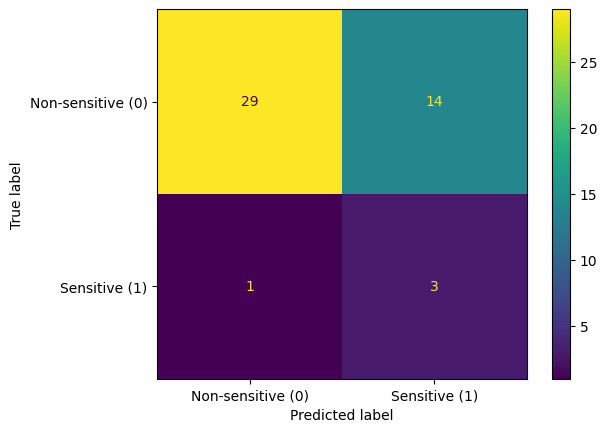

{'accuracy': 0.6808510638297872, 'f1_score': 0.7512178873298082, 'balanced accuracy': 0.7122093023255813}


In [203]:
mr = main_experiment('n', 50, True, 'Mistral', 'v2', b1, '[/INST]', tokenizer, model)


In [204]:
mr

{'177860_0': '[/INST] \n The text does not contain any personal information that can be identified.',
 '177860_1': '[/INST] \n The text does contain personal information, but it is in a professional',
 '54263_0': '[/INST] \n The text does not contain any personal information that is not related to',
 '54263_1': '[/INST] \n The text does not contain any overtly personal information. The',
 '54263_2': '[/INST] \n The text does not contain any personal information that can be identified.',
 '54263_5': '[/INST] \n The text does not contain purely personal information. The message is related',
 '54629_0': '[/INST] \n The text does not contain any personal information that is not related to',
 '54629_1': '[/INST] \n The text does contain some personal information, such as the names of',
 '175555_0': '[/INST] \n The text does not contain any personal information that can be identified in',
 '175555_1': '[/INST] \n The text does not contain any overtly personal information. The',
 '173234': '[

### Chain of thought
Another prompt family is chain of thought, where we can put the first response as input to the model as useful context. We attempted to constrain the above output into a Python list as before, but this reduced classification accuracy. Therefore, analysing the generated statement may help to produce processible outputs.

This involved copying above functions and can be refactored.

In [69]:
def llm_inference(document, prompt, model, tokenizer):
  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
  encodeds = tokenizer(prompt(document), return_tensors="pt")
  device = 'cuda'
  model_inputs = encodeds.to(device)
  generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, pad_token_id=tokenizer.pad_token_id, max_new_tokens=150, do_sample=False) #, top_k=40, num_beams=4, temperature=0.7, top_p=0.95)
  decoded = tokenizer.batch_decode(generated_ids)
  del model_inputs
  torch.cuda.empty_cache()
  gc.collect()
  return decoded[0]

def llm_inferencehoptwo(document, prompt, model, tokenizer, response, hopprompt):
    if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token
    messages = [
    {"role": "user", "content": prompt(document)},
    {"role": "assistant", "content": response},
    {"role": "user", "content": hopprompt()}
    ]
    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    arr_like = torch.ones_like(model_inputs)
    attention_mask = arr_like.to(device)
    generated_ids = model.generate(inputs=model_inputs, attention_mask=attention_mask, pad_token_id=tokenizer.pad_token_id, max_new_tokens=50, do_sample=False)
    decoded = tokenizer.batch_decode(generated_ids)
    return decoded[0]

def post_process_classification(classification, ground_truth):
    if "no personal information" in classification.lower(): #"non-personal"
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0
    
    elif "personal information" in classification.lower(): # "personal"
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification


# New main prompt
def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? \nMessage: {document} \n[/INST] \n The text does"

# Asking for set classification
def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? Classify the message as either personal or non-personal. \nMessage: {document} \n[/INST] \nClassification:"

# Python output list - didn't really work
def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? Classify the message as either personal or non-personal. Write your answer in the form of a Python list containing the only appropriate attribute and provide no further explanation.\nMessage: {document} \n[/INST] \nClassification:"


# Document placement comparison - b2 performs worse compared to b1. Does question dominate output due to being so close to next token.
def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. \nMessage: {document} \n\nClassify the message as either personal or non-personal. You must answer after 'Classification', and provide no further explanation. [/INST] \nClassification:"
def b2(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. \nClassify the message as either personal or non-personal. You must answer after 'Classification', and provide no further explanation. \nMessage: {document} [/INST] \nClassification:"


# CoT
def hopone(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? \nMessage: {document} \n[/INST] \nThe text does"
def hoptwoinit(document):
  return f"Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? \nMessage: {document} \n"
def hoptwo():
  return f"\nBased on your response would you classify the text as containing 'personal information' or 'no personal information' You must answer with 'personal information' or 'no personal information'. \n"



Copied functions for extra parameters for hop prompts.

In [70]:
# Dataset - dataframe, prompt_strategy - prompt function name
def llm_experiment(dataset, prompt_strategy, p2init, p2, model, tokenizer, end_prompt=None):
    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    further_processing_required = {}
    # All model output
    model_responses = {}

    scikit_true = []
    scikit_pred = []

    for sample in dataset.iterrows():
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # To replace with appropriate pre-processing
        if len(sample_text) > 10000:
            continue
        
        classification = prompt_to_reply(sample_text, prompt_strategy, model, tokenizer, p2init, p2, end_prompt)

        model_responses[sample[1].doc_id] = classification

        quadrant, pred = post_process_classification(classification, ground_truth)
        if pred == None:
            further_processing_required[sample[1].doc_id] = quadrant
            continue

        predictions[quadrant] = predictions.get(quadrant) + 1
        scikit_true.append(ground_truth)
        scikit_pred.append(pred)

        #clear_memory()

    return predictions, further_processing_required, model_responses, scikit_true, scikit_pred

def prompt_to_reply(d, p, model, tokenizer, p2init, p2, end):
  response = llm_inference(d, p, model, tokenizer)
  response = display_gen_text(response, end)
  response2 = llm_inferencehoptwo(d, p2init, model, tokenizer, response[8:], p2)
  split = response2.split('[/INST]')
  print(split[-1])
  return display_gen_text('[/INST]' + split[-1], end)

def main_experiment(portion, portion_value, proc_meth, m, v, prompt_strategy, ps2in, ps2, end_prompt, tokenizer, model):
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    if portion == 'n':
        samp = get_sample_n(sara_df, portion_value)

    if proc_meth:
        proc_samp = proccutit(samp)

    predictions, further_processing_required, model_responses, truths, preds = llm_experiment(proc_samp, prompt_strategy, ps2in, ps2, model, tokenizer, end_prompt)
    new_preds, new_truths = post_process_split_docs(model_responses, further_processing_required, preds, sara_df)
    print(new_preds)
    print(new_truths)
    evaluation_summary("Llama-2", new_truths, new_preds)
    get_metric_dict("Llama-2", new_truths, new_preds)
    return model_responses, predictions

 No personal information.</s>
 Personal information.</s>
 Personal information. However, it is important to note that the information is being shared in a professional context related to work.</s>
 Based on my previous response, the text contains personal information, but it is in a professional context.</s>
 Based on my analysis, the text contains no personal information.</s>
 The text contains no personal information in a purely personal sense. It contains professional contact information and a work-related invitation.</s>
 No personal information.</s>
 Personal information.</s>
 Based on the given text, I would classify it as containing "no personal information".</s>
 Based on the text provided, I would classify it as containing "no personal information." The message is focused on a business matter and does not contain any mention of personal details or emotions unrelated to the professional context.</s>
 Based on the given text, I would classify it as containing "personal informati

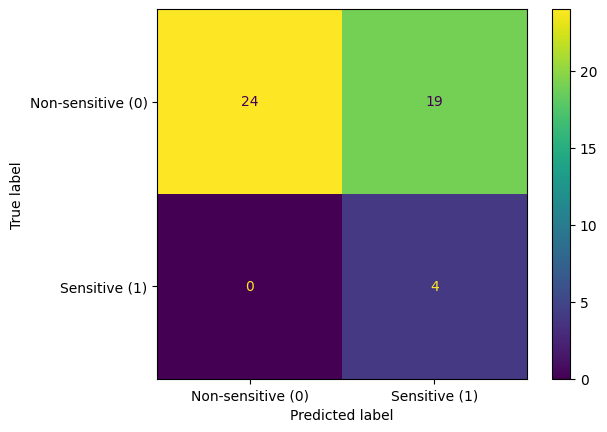

{'accuracy': 0.5957446808510638, 'f1_score': 0.6806628794561471, 'balanced accuracy': 0.7790697674418605}


In [74]:
mr = main_experiment('n', 50, True, 'Mistral', 'v2', hopone, hoptwoinit, hoptwo, '[/INST]', tokenizer, model)


In [75]:
mr

{'177860_0': '[/INST] No personal information.</s>',
 '177860_1': '[/INST] Personal information.</s>',
 '54263_0': '[/INST] Personal information. However, it is important to note that the information is being shared in a professional context related to work.</s>',
 '54263_1': '[/INST] Based on my previous response, the text contains personal information, but it is in a professional context.</s>',
 '54263_2': '[/INST] Based on my analysis, the text contains no personal information.</s>',
 '54263_5': '[/INST] The text contains no personal information in a purely personal sense. It contains professional contact information and a work-related invitation.</s>',
 '54629_0': '[/INST] No personal information.</s>',
 '54629_1': '[/INST] Personal information.</s>',
 '175555_0': '[/INST] Based on the given text, I would classify it as containing "no personal information".</s>',
 '175555_1': '[/INST] Based on the text provided, I would classify it as containing "no personal information." The messa

### Few shot

In [ ]:
y = ['54604', '174137', '54548', '54600']

In [ ]:
s = get_sara()
s = dataset_to_df(s)
proc = proccutit(s)

#54600_0 for non-sens, 54604_1 for sens
few = ['54600_0', '54604_1']
for l in proc.iterrows():
    idd = l[1].doc_id
    if idd in few:
        t = l[1].text
        print(t)
        print(len(t))

Vince,
Hope you are well.  
We've been in contact with Rice University's bookshop and they informed us  that they have a few books left over from the course.  We told them  originally that if they didn't sell them all we would take them back.  We  would rather have them sent over to you as complimentary copies if that's  OK with you?
What's new?  Busy summer so far?  Hope that the storm didn't  cause you any problems.
Julie
427
Aruna,
I shall be in London this week. Please, call me on Monday next week. 
Best time is between 7:30 and 8:30  my time.
Vince
127


In [ ]:
global_sens = proc[proc.doc_id == '54604_1'].text.iloc[0]
global_nonsens = proc[proc.doc_id == '54548_1'].text.iloc[0] #54548_1


In [ ]:
def post_process_classification(classification, ground_truth):
    #print(classification.lower())
    if "does contain" in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1
    
    elif "does not contain" in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0
    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification

Few shot prompts with alternative instruction tags. As examples are 'model responses'.

In [ ]:
def b1(document):
  return f"""[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context?

Example:
Message: {global_sens}
Response: The text does contain personal information.

Message: {global_nonsens}
Response: The text does not contain personal information.

Now answer:
Message: {document}. \n[/INST]
Response: The text does"""

def b1(document):
  return f"""[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context?  [/INST]

Example:
Message: {global_sens}
Response: The text does contain personal information.

Example:
Message: {global_nonsens}
Response: The text does not contain personal information.

Now answer:
Message: {document}.
Response: The text does"""

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.920     0.633     0.750       128
    Sensitive (1)      0.130     0.500     0.206        14

         accuracy                          0.620       142
        macro avg      0.525     0.566     0.478       142
     weighted avg      0.842     0.620     0.696       142



Confusion matrix:


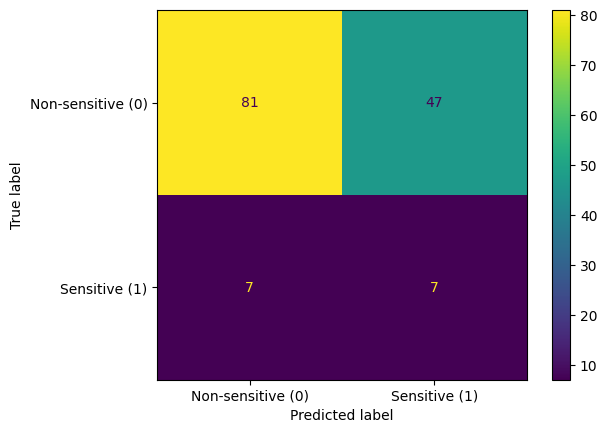

{'accuracy': 0.6197183098591549, 'f1_score': 0.696354598177299, 'balanced accuracy': 0.56640625}


In [ ]:
mr = main_experiment('n', 150, True, 'Mistral', 'v2', b1, '\nNow answer:', tokenizer, model)


In [ ]:
mr

{'177860_0': '\nNow answer:\nMessage: Call at 5:00 today (3:00 your time), if you can..\nResponse: The text does not contain personal information.</s>',
 '177860_1': "\nNow answer:\nMessage: Steve\nGood news.  As you indicated would happen, Kalen Pieper called me mid-week.  We had a very good conversation about EES and Dave Delainey's leadership.  She explored my views about doing business with government.  Shortly thereafter, Dave's office called to invite me to Houston on Thursday July 26.  \nKay Chapman explained that Dave's schedule would keep him out of pocket until August 16.  In order to move forward, Janet Dietrich will be meeting with me when I go to Houston next Thursday.  (I must confess that after all the great things I have heard about the man, I do look forward to meeting Dave himself.)\nIs there a time next week that I can speak with you by phone to fine-tune my thinking / preparation for Thursday's meeting with Janet?\nThank you for your all of your help.  I am pleased 

In [ ]:
for m in mr.values():
    fin = m.find('Response:')
    print(m[fin:])

Response: The text does not contain personal information.</s>
Response: The text does contain personal information.</s>
Response: The text does not contain personal information.</s>
Response: The text does not contain personal information.</s>
Response: The text does not contain personal information.</s>
Response: The text does not contain personal information.</s>
Response: The text does not contain personal information.

Message: Mike
Response: The text does not contain personal information.</s>
Response: The text does not contain personal information.

Message: 
Response: The text does not contain personal information.</s>
Response: The text does not contain any discernible personal information. It
Response: The text does not contain personal information.</s>
Response: The text does not contain personal information.

Message: 
Response: The text does not contain personal information.</s>
Response: The text does contain personal information.</s>
Response: The text does not contain pe

Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      1.000     0.667     0.800         3
    Sensitive (1)      0.667     1.000     0.800         2

         accuracy                          0.800         5
        macro avg      0.833     0.833     0.800         5
     weighted avg      0.867     0.800     0.800         5



Confusion matrix:


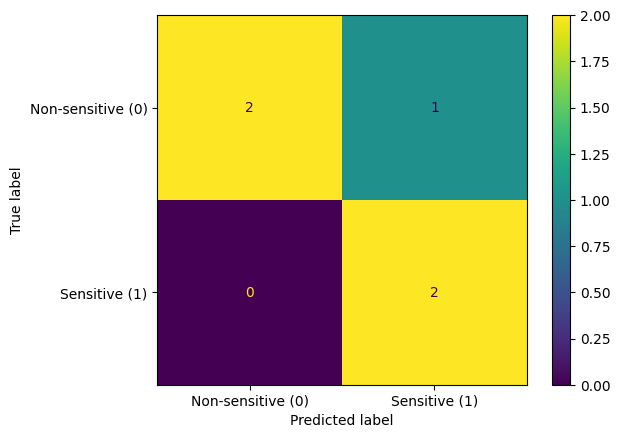

{'accuracy': 0.8, 'f1_score': 0.8, 'balanced accuracy': 0.8333333333333333}


In [ ]:
def b1(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? [/INST] \n\nExample:\nMessage: Vince,\nHope you are well.  \nWe've been in contact with Rice University's bookshop and they informed us  that they have a few books left over from the course.  We told them  originally that if they didn't sell them all we would take them back.  We  would rather have them sent over to you as complimentary copies if that's  OK with you?\nWhat's new?  Busy summer so far?  Hope that the storm didn't  cause you any problems.\nJulie\nResponse: The text does contain personal information.\n\nExample:\nMessage: Aruna,\nI shall be in London this week. Please, call me on Monday next week. \nBest time is between 7:30 and 8:30  my time.\nVince\nResponse: The text does not contain personal information.\n\nNow answer:\nMessage: {document}.\nResponse: The text does"


mr = main_experiment('n', 5, True, 'Mistral', 'v2', b1, '\nNow answer:', tokenizer, model)

In [ ]:
for m in mr.values():
    fin = m.find('Response:')
    print(m[fin:])

Response: The text does not contain personal information.</s>
Response: The text does contain personal information, but it is in a professional
Response: The text does not contain personal information.

Message: Philip
Response: The text does not contain personal information.

Explanation
Response: The text does not contain personal information.

Message: Philip
Response: The text does contain personal information, but it is in a professional
Response: The text does not contain personal information.

Message: Mike
Response: The text does contain personal information, including Mike Boughton'
Response: The text does not contain personal information.

Explanation
Response: The text does not contain personal information.

Explanation
Response: The text does not contain personal information.

Explanation


Using these examples create 525 additional tokens. We see below, documents under 10,000 characters (in our experiment as a limit) are ~9000 at most, so this additional text should not crash the model.

In [ ]:
additional = f"""Example:
Message: {global_sens}
Response: The text does contain personal information.

Message: {global_nonsens}
Response: The text does not contain personal information.

Now answer:
Message: \n[/INST]
Response: The text does"""
addtokens = tokenizer(additional, return_tensors='pt')
print(len(addtokens.input_ids[0]))

525


In [ ]:
s = get_sara()
s = dataset_to_df(s)
proc = proccutit(s)
f = proc.text.str.len()

In [ ]:
y = f.tolist()
l = sorted(y, reverse=True)

In [ ]:
l[25:]

[9135,
 8529,
 8514,
 8130,
 8008,
 8004,
 7241,
 7241,
 6707,
 6380,
 6377,
 6377,
 6339,
 6178,
 5946,
 5752,
 5727,
 5726,
 5668,
 5605,
 5519,
 5439,
 5402,
 5304,
 5304,
 5224,
 5121,
 5116,
 5087,
 5079,
 5068,
 5060,
 4966,
 4910,
 4833,
 4811,
 4804,
 4781,
 4781,
 4642,
 4611,
 4588,
 4490,
 4430,
 4396,
 4321,
 4246,
 4165,
 4126,
 4101,
 4077,
 4043,
 3892,
 3818,
 3799,
 3789,
 3602,
 3596,
 3596,
 3590,
 3574,
 3564,
 3523,
 3497,
 3381,
 3293,
 3272,
 3261,
 3237,
 3219,
 3174,
 3169,
 3142,
 3142,
 3090,
 3090,
 3090,
 3086,
 3085,
 3021,
 2957,
 2957,
 2956,
 2940,
 2934,
 2916,
 2916,
 2901,
 2895,
 2876,
 2875,
 2869,
 2865,
 2845,
 2792,
 2780,
 2766,
 2753,
 2692,
 2692,
 2692,
 2687,
 2687,
 2613,
 2613,
 2612,
 2584,
 2576,
 2571,
 2571,
 2571,
 2571,
 2563,
 2552,
 2549,
 2535,
 2489,
 2481,
 2454,
 2453,
 2453,
 2424,
 2424,
 2397,
 2395,
 2358,
 2348,
 2335,
 2333,
 2333,
 2317,
 2317,
 2294,
 2293,
 2284,
 2283,
 2272,
 2261,
 2261,
 2261,
 2231,
 2231,
 2210,

Prompts used during development and to identify what changes cause the main effects

In [ ]:
# Note: post_process_classification is modified to classify non-personal/personal or purely personal/personal in a professional context/non-personal

# Choose personal instead of sensitive
def b2(document):
  return f"Which one of the attributes 'personal', 'non-personal' describes the message? \nMessage: {document} \n[/INST] \n Attribute: "
def b2(document):
  return f"Which one of the attributes 'personal', 'non-personal' describes the message? Write your answer in the form of a Python list containing the only appropriate attribute and provide no further explanation, for example ['personal'] or ['non-personal']. \nMessage: {document} \n[/INST] \n Classification:"
def b2(document):
    return f"The 'personal' attribute describes purely personal messages and personal but in a professional context messages. Which one of the attributes 'personal', 'non-personal' describes the message? Write your answer in the form of a Python list containing the only appropriate attribute and provide no further explanation, for example ['personal'] or ['non-personal']. \nMessage: {document} \n[/INST] \n Classification:"

# Let a choice from 3, 2 being sensitive
def b2(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Which one of the attributes 'purely personal', 'personal but in a professional context', 'non-personal' describes the message? \nMessage: {document} \n[/INST] \n Classification:"
# The multi-choice classification, formatted this way (second has additional info)
# Many being classified under professional personal
def b2(document):
  return f"""[INST] Your task is to determine if the email message from a work email contains personal information. Which one of the attributes 'purely personal', 'personal but in a professional context', 'non-personal' describes the message? 
Where,
'purely personal' messages include personal information and do not include any relation to work being done. 
'personal but in a professional context' messages include personal information and do include a relation to work being done. 
'non-personal' messages include all other emails.

Message: {document} \n[/INST] \n Classification:"""
def b2(document):
  return f"""[INST] Your task is to determine if the email message from a work email contains personal information. Which one of the attributes 'purely personal', 'personal but in a professional context', 'non-personal' describes the message? 
Where,
'purely personal' messages include personal information and do not include any relation to work being done. 
'personal but in a professional context' messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment.
'non-personal' messages include all other emails.

Message: {document} \n[/INST] \n Classification:"""


def b2(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Which one of the attributes 'personal', 'non-personal' describes the message? Write your answer in the form of a Python list containing the only appropriate attribute and provide no further explanation, for example ['personal'] or ['non-personal']. \nMessage: {document} \n[/INST] \n Classification:"
def b2(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? Write your answer in the form of a Python list containing the only appropriate attribute and provide no further explanation, for example ['personal'] or ['non-personal']. \nMessage: {document} \n[/INST] \n Classification:"
def b2(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Does the message contain purely personal information or information that is personal a professional context? Write your answer in the form of a Python list, using ['personal'] if the message contains purely personal information or information that is personal a professional context and ['non-personal'] for all other documents. \nMessage: {document} \n [/INST] \nClassification:"


def b2(document):
  return f"[INST] Your task is to determine if the email message from a work email contains personal information. Purely personal messages include personal information and do not include any relation to work being done. Personal but in a professional context messages include personal information that are related to work, for example comments about the quality of people's work and expressions of feelings about employee treatment. Which one of the attributes 'personal', 'non-personal' describes the message? You must answer with 'personal' or 'non-personal'. \nMessage: {document} \n[/INST] \nClassification:"
#You must answer with in the form of a Python list containing the only appropriate attribute. \nMessage: {document} \n[/INST] \nClassification:"
